In [1]:
import os
import cv2
import glob
from glob import glob
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from collections import defaultdict

Using TensorFlow backend.


In [2]:
def show(X):
    display(Image.fromarray(X))

In [3]:
train_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TRAIN_NOSEG_64.npy')
test_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TEST_NOSEG_64.npy')
train = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TRAIN.csv')
test = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TEST.csv')
test_id = test.image.values

In [8]:
train_data = np.delete(train_data, sorted(clean_index), 0)

In [10]:
train = train.drop(sorted(clean_index)).reset_index(drop=True)

In [12]:
train_data.shape, train.shape

((7507, 64, 64, 3), (7507, 4))

In [13]:
test_stg2 = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/TEST_STG2.csv')
test_stg2_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TEST_STG2_NOSEG_64.npy')
test_stg2_id = test_stg2.image.values

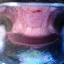

In [14]:
show(train_data[700])

In [15]:
train_data.shape

(7507, 64, 64, 3)

In [16]:
train_data_ud = train_data[:,::-1,:,:]

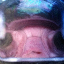

In [17]:
show(train_data_ud[700])

In [18]:
train_data_rl = train_data[:,:,::-1,:]

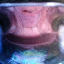

In [19]:
show(train_data_rl[700])

In [20]:
def rotation(image, angle):
    assert image.shape[-1] == 3
    num_rows, num_cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), angle, 1)
    img_rotation = cv2.warpAffine(image, rotation_matrix, (num_cols, num_rows))
    return img_rotation

In [21]:
rot_num = 12
rot_imgs = defaultdict(list)
for i in range(train_data.shape[0]):
    for rot in range(int(360/rot_num),360,int(360/rot_num)):
        rot_img = rotation(train_data[i,:,:,:], rot)
        rot_imgs[rot].append(rot_img)

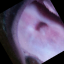

In [22]:
show(rot_imgs[30][800])

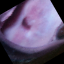

In [23]:
show(rot_imgs[120][800])

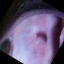

In [24]:
show(rot_imgs[330][800])

In [25]:
train_data = np.concatenate([train_data, train_data_ud, train_data_rl,\
                             np.array(rot_imgs[30]),np.array(rot_imgs[60]),\
                             np.array(rot_imgs[90]),np.array(rot_imgs[120]),\
                             np.array(rot_imgs[150]),np.array(rot_imgs[180]),\
                             np.array(rot_imgs[210]),np.array(rot_imgs[240]),\
                             np.array(rot_imgs[270]),np.array(rot_imgs[300]),\
                             np.array(rot_imgs[330])])

In [26]:
train_data.shape

(105098, 64, 64, 3)

### 增加亮度 

In [27]:
train_data_light = (train_data * 1.2).clip(0,255).astype(np.uint8)

In [28]:
train_data_light.shape

(105098, 64, 64, 3)

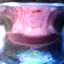

In [29]:
show(train_data_light[700])

### 減少亮度 

In [30]:
train_data_non_light = (train_data * 0.8).clip(0,255).astype(np.uint8)

In [31]:
train_data_non_light.shape

(105098, 64, 64, 3)

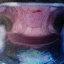

In [32]:
show(train_data_non_light[700])

### 組合

In [33]:
train_X = np.concatenate([train_data,train_data_light,train_data_non_light])

In [34]:
train_X.shape

(315294, 64, 64, 3)

In [35]:
le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)
train_Y = np.concatenate([train_target for i in range(14*3)])

In [36]:
train_X.shape, train_Y.shape

((315294, 64, 64, 3), (315294,))

In [37]:
random_index = np.random.choice(range(train_X.shape[0]), train_X.shape[0], replace = False)

In [38]:
train_X = train_X[random_index]
train_Y = train_Y[random_index]

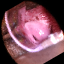

In [39]:
show(train_X[1000])

In [40]:
# x_train, x_val_train, y_train, y_val_train =\
# train_test_split(train_X, train_Y, test_size = 0.1, random_state=17)
x_train = train_X
y_train = train_Y

In [41]:
x_train.shape, y_train.shape#, x_val_train.shape, y_val_train.shape

((315294, 64, 64, 3), (315294,))

In [42]:
# 3種 Type
num_classes = 3
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val_train = keras.utils.to_categorical(y_val_train, num_classes)

In [43]:
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [46]:
model = Sequential()
model.add(Reshape((64, 64, 3), input_shape = x_train.shape[1:]))
model.add(Conv2D(16, (3, 3), padding='valid',data_format = "channels_last"))
model.add(Conv2D(16, (3, 3), padding='valid',data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='valid',  data_format = "channels_last"))
model.add(Conv2D(32, (3, 3), padding='valid',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='valid',  data_format = "channels_last"))
model.add(Conv2D(64, (3, 3), padding='valid',  data_format = "channels_last"))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='valid',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(12))
model.add(Activation('tanh'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 16)        2320      
_________________________________________________________________
activation_13 (Activation)   (None, 60, 60, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        4640      
__________

In [47]:
earlystopping = EarlyStopping(monitor='val_loss', patience=2)
adam = Adam(lr = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [48]:
x_train = x_train.astype('float32')
#x_val_train = x_val_train.astype('float32')

x_train /= 255
#x_val_train /= 255

x_test = test_data.astype('float32')
x_test /= 255

In [49]:
x_test_stg2= test_stg2_data.astype('float32')
x_test_stg2 /= 255

In [74]:
model.fit(x_train,
          y_train,
          batch_size = 256,
          epochs = 50,
          validation_split = 0.25,
          callbacks=[earlystopping])

Train on 236470 samples, validate on 78824 samples
Epoch 1/50
236470/236470 [==============================] - 67s - loss: 0.7611 - acc: 0.6429 - val_loss: 0.7074 - val_acc: 0.6755

In [75]:
pred = model.predict_proba(x_test)

384/512 [=====================>........] - ETA: 0s

In [76]:
df = pd.DataFrame(pred, columns=['Type_1','Type_2','Type_3'])
df['image_name'] = test_id
df = df[['image_name','Type_1','Type_2','Type_3']]

In [77]:
sample_submission =\
pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/sample_submission.csv')

In [78]:
for name in sample_submission['image_name']:
    #print(name)
    #sub[name] = df[df['image_name'] == name][['Type_1','Type_2','Type_3']].values.tolist()[0]
    #print(name)
    Type_1 = df.loc[df['image_name'] == name, 'Type_1']
    Type_2 = df.loc[df['image_name'] == name, 'Type_2']
    Type_3 = df.loc[df['image_name'] == name, 'Type_3']
    
    Type_1_index = Type_1.index[0]
    Type_2_index = Type_2.index[0]
    Type_3_index = Type_3.index[0]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_1'] = Type_1[Type_1_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_2'] = Type_2[Type_2_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_3'] = Type_3[Type_3_index]

In [79]:
sample_submission.head(10)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.134688,0.827631,0.037681
1,1.jpg,0.046012,0.554040,0.399948
2,2.jpg,0.393913,0.583157,0.022929
3,3.jpg,0.024735,0.377543,0.597723
4,4.jpg,0.018967,0.494578,0.486455
5,5.jpg,0.151226,0.808794,0.039980
6,6.jpg,0.166638,0.777561,0.055802
7,7.jpg,0.327693,0.325826,0.346482
8,8.jpg,0.228907,0.736255,0.034839
9,9.jpg,0.095250,0.728068,0.176682


In [80]:
True_outcome = pd.read_csv('/home/dataset/solution_stg1_release.csv')

In [81]:
True_outcome.head(10)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0,1,0
1,1.jpg,0,1,0
2,2.jpg,1,0,0
3,3.jpg,0,0,1
4,4.jpg,0,0,1
5,5.jpg,0,1,0
6,6.jpg,0,1,0
7,7.jpg,0,1,0
8,8.jpg,0,1,0
9,9.jpg,0,1,0


In [82]:
Pred = sample_submission[["Type_1","Type_2","Type_3"]].values# * 0 + 0.5

In [83]:
Ober = True_outcome[["Type_1","Type_2","Type_3"]].values

In [84]:
func = lambda y, p: y * np.log(max(min(p, 1-10e-15),10e-15))
log_loss = 0.0
for i in range(0, sample_submission.shape[0], 1):

    log_loss += np.sum(np.array(list(map(func, Ober[i], Pred[i]))))
    #print(log_loss)
log_loss /= (-1.) * sample_submission.shape[0]

In [85]:
log_loss

0.80839255884347949

In [65]:
pred_stg2 = model.predict_proba(x_test_stg2)
df_stg2 = pd.DataFrame(pred_stg2, columns=['Type_1','Type_2','Type_3'])
df_stg2['image_name'] = test_stg2_id
df_stg2 = df_stg2[['image_name','Type_1','Type_2','Type_3']]

3506/3506 [==============================] - 0s     


In [66]:
df_stg2.head()

,image_name,Type_1,Type_2,Type_3
0,12708.jpg,0.018968,0.259533,0.721499
1,13284.jpg,0.017568,0.260081,0.722351
2,11551.jpg,0.145187,0.556292,0.298521
3,11151.jpg,0.038850,0.814001,0.147149
4,11643.jpg,0.494345,0.474651,0.031004


In [71]:
df_stg2.shape

(3506, 4)

In [72]:
df_stg2_submission = pd.concat([sample_submission, df_stg2]).reset_index(drop=True)

In [73]:
df_stg2_submission.to_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/submission_LB05_CD_stg2.csv', index=False)

In [5]:
clean_index = [7,14,17,22,23,\
               32,38,43,45,46,\
               48,49,52,59,63,\
               66,71,73,74,82,\
               91,97,99,109,122,\
               124,125,126,132,141,\
               143,153,154,162,171,\
               176,181,183,192,193,\
               201,206,217,218,226,\
               234,235,237,247,251,\
               270,271,286,292,294,\
               301,311,314,325,338,\
               347,355,359,361,367,\
               374,376,385,391,394,\
               412,434,460,493,498,\
               503,506,530,542,545,\
               546,564,572,573,595,\
               601,604,617,631,649,\
               652,659,704,705,711,\
               711,713,750,792,814,\
               842,871,882,890,908,\
               910,912,933,946,961,\
               963,975,978,987,1008,\
               1024,1033,1034,1035,1065,\
               1075,1077,1080,1082,1100,\
               1104,1121,1131,1133,1140,\
               1143,1152,1164,1167,1175,\
               1177,1190,1200,1205,1206,\
               1231,1240,1252,1254,1255,\
               1258,1264,1275,1295,1331,\
               1336,1347,1350,1352,1364,\
               1382,1386,1387,1416,1462,\
               1480,1482,1491,1498,1507,\
               1513,1514,1516,1518,1520,\
               1521,1525,1531,1534,1537,\
               1547,1549,1552,1558,1561,\
               1563,1576,1585,1587,1616,\
               1617,1639,1645,1652,1668,\
               1701,1705,1722,1732,1735,\
               1737,1756,1784,1792,1797,\
               1799,1807,1812,1823,1834,\
               1840,1843,1849,1850,1858,\
               1859,1864,1870,1877,1898,\
               1899,1900,1901,1902,1903,\
               1904,1919,1928,1931,1933,\
               1941,1951,1952,1962,1964,\
               1969,1971,1972,1974,1975,\
               1979,1990,1994,1996,1998,\
               2004,2022,2024,2029,2037,\
               2040,2041,2063,2069,2073,\
               2081,2103,2136,2143,2144,\
               2145,2147,2154,2157,2183,\
               2184,2189,2196,2203,2204,\
               2208,2218,2236,2240,2244,\
               2263,2267,2272,2301,2315,\
               2321,2327,2337,2247,2357,\
               2374,2376,2381,2384,2397,\
               2425,2435,2461,2465,2466,\
               2482,2489,2525,2532,2594,\
               2604,2612,2628,2629,2630,\
               2634,2641,2645,2646,2661,\
               2669,2672,2675,2676,2690,\
               2691,2713,2737,2738,2741,\
               2744,2748,2749,2751,2758,\
               2760,2765,2784,2795,2812,\
               2814,2832,2847,2859,2864,\
               2884,2887,2893,2897,2906,\
               2909,2949,2968,2979,3000,\
               3002,3033,3034,3036,3048,\
               3084,3087,3095,3128,3132,\
               3167,3195,3203,3220,3221,\
               3233,3236,3237,3243,3249,\
               3266,3276,3275,3285,3295,\
               3317,3321,3341,3365,3381,\
               3393,3408,3410,3411,3417,\
               3446,3448,3450,3503,3504,\
               3513,3587,3607,3608,3652,\
               3667,3698,3741,3749,3757,\
               3778,3789,3809,3810,3815,\
               3833,3835,3871,3903,3912,\
               3913,3958,3965,4036,4037,\
               4080,4101,4114,4212,4218,\
               4249,4269,4281,4289,4295,\
               4299,4341,4375,4393,4397,\
               4416,4417,4425,4443,4447,\
               4459,4475,4481,4493,4509,\
               4550,4554,4555,4573,4574,\
               4577,4595,4609,4620,4627,\
               4630,4666,4667,4680,4702,\
               4785,4802,4804,4814,4846,\
               4875,4911,4991,5000,5014,\
               5017,5019,5048,5051,5059,\
               5083,5146,5167,5158,5193,\
               5195,5205,5241,5243,5255,\
               5256,5320,5327,5356,5383,\
               5400,5411,5418,5425,5487,\
               5489,5506,5518,5532,5538,\
               5543,5551,5592,5595,5606,\
               5607,5626,5627,5635,5636,\
               5645,5650,5671,5756,5760,\
               5767,5771,5772,5775,5778,\
               5779,5782,5783,5829,5843,\
               5859,5860,5863,5869,5875,\
               5881,5947,5964,6052,6085,\
               6101,6111,6117,6120,6130,\
               6132,6153,6155,6156,6165,\
               6181,6182,6212,6241,6283,\
               6294,6295,6312,6360,6365,\
               6493,6404,6414,6444,6459,\
               6462,6475,6478,6498,6519,\
               6527,6530,6585,6593,6594,\
               6621,6665,6668,6689,6700,\
               6715,6718,6726,6734,6736,\
               6747,6749,6759,6834,6889,\
               6895,6901,6904,6905,6908,\
               6918,6949,6956,7011,7110,\
               7127,7131,7151,7152,7166,\
               7170,7218,7223,7227,7241,\
               7245,7263,7264,7269,7272,\
               7301,7346,7349,7351,7376,\
               7377,7440,7516,7556,7581,\
               7582,7605,7617,7620,7628,\
               7642,7648,7651,7681,7689,\
               7690,7691,7702,7732,7737,\
               7752,7757,7758,7761,7764,\
               7770,7775,7778,7791,7810,\
               7812,7826,7830,7836,7844,\
               7849,7853,7855,7865,7872,\
               7885,7889,7900,7901,7904,\
               7916,7919,7920,7923,7925,\
               7929,7931,7934,7935,7936,\
               7938,7939,7940,7941,7949,\
               7950,7951,7953,7962,7971,\
               7974,7976,7982,7983,7984,\
               7994,8003,8006,8012,8013,\
               8025,8032,8041,8042,8045,\
               8046,8047,8049,8051,8053,\
               8055,8059,8060,8061,8062,\
               8065,8070,8071,8083,8093,\
               8095,8096,8104,8109,8128,\
               8154,8165,8171,8194,8198,\
               8211]